# A/B Testing Simulation for Marketplace Platform

## Introduction to A/B Testing and Project Goals
### A/B Testing

A/B testing is a powerful statistical method used to compare two versions of a product, feature, or system to determine which performs better. It involves splitting users into two groups—**Control** (the current version) and **Treatment** (the new version)—and measuring the impact on key performance metrics. By randomly assigning users and analyzing the results, A/B testing helps make data-driven decisions.

### Project Goals

In this notebook, we’ll step into the shoes of a data team at **The Guild**, a fictional gig marketplace platform. Our mission? Evaluate whether a revamped **ranking algorithm** does a better job at recommending relevant job requests to our supply-side users—adventurers, or service providers.

The Guild already had a ranking system in place, but it was built over three years ago. As the platform evolved, we suspected that the original algorithm might be outdated. We started tracking events when users open to see details of a job requets and when they accept a job request, then analyzed, and concluded that the original algorithm no longer reflects how our suppliers behave or what they prioritize. So we went back to the drawing board—reanalyzed the key factors driving job acceptance, redesigned the algorithm, and now we’re ready to put it to the test.

To do that, we’ll simulate an **A/B test** comparing the old and new algorithms. Our goal is to see whether the new algorithm increases supplier efficiency by putting more relevant job requests right at the top of their screens, so no scrolling needed.

Let’s walk through how we’ll design the experiment, measure success, and make a decision—just like a real data team at The Guild would.

- **Target Metric**: Increase the **Top K Accepting Rate** (acceptance rate of the top 3 job requests).
- **Guardrail Metrics**: Ensure no significant negative impact on:
  - **Overall Acceptance Rate**
  - **Time to Accept**
- **Informative Metrics**: Gain insights from:
  - **Average Position of Accepted Job Requests**.
  - **Acceptance Rate at Selected Order**.

We’ll use simulated data to compare the current ranking algorithm (Control) against the new revamped ranking (Treatment) to decide whether to launch the new algorithm.


---

## Experiment Design

### Variants

- **Control (A)**: Job requests are ranked using the current algorithm.
- **Treatment (B)**: Job requests are ranked using the new algorithm.

### Metrics

#### Metric Definitions and Rationale

In this section, we explain the three types of metrics used in the experiment: **Target**, **Guardrail**, and **Informative**. Each metric includes its purpose, formula, and why it matters.



---

#### Target Metric

##### **Top‑K Acceptance Rate (K=3)**  
- **Purpose**: Measures if the new algorithm places more *relevant* job requests in the top positions.
- **Definition**: The percentage of accepted job requests that were ranked within the top K positions—i.e., shown among the first 3 jobs (K=3) without scrolling, on the screen when the supplier decided to accept. 
- **Formula**:  
$$
\text{Top-}K\ \text{Acceptance Rate} = \frac{\#\ \text{of accepts within top } K\ \text{positions}}{\#\ \text{of total accepts}}
$$


- **Goal**: **Increase**. A higher rate means the top 3 jobs are more relevant and likely to be accepted.

---

#### Guardrail Metrics

These metrics ensure that overall platform performance and user experience are **not negatively impacted** by the new algorithm.

##### 1. **Overall Acceptance Rate**  
- **Definition**: Proportion of recommended job requests that are accepted.  
- **Formula**:  
  $$
  \text{Overall Acceptance Rate} = \frac{\text{\# accepted job requests}}{\text{total \# job requests}}
  $$

- **Goal**: **Stay stable or improve**. A significant drop could signal reduced engagement or quality.

##### 2. **Time to Accept (Median & 90th Percentile)**  
- **Definition**: Time (in seconds) from when the list is shown to when a job request is accepted.  
- **Formula**:  
  $$
  \text{Time to Accept} = \text{timestamp}_{accept} - \text{timestamp}_{list\_shown}
  $$
  Then compute:  
  - **Median (P50)**: typical supplier experience  
  - **90th Percentile (P90)**: slowest 10% of suppliers  
- **Goal**: **Lower or unchanged**. Longer times could mean more friction in finding good jobs.

---

#### 📊 Informative Metrics

These metrics help explain *why* a result occurred and guide future improvements.

##### 1. **Median Position of Accepted Job Requests**  
- **Definition**: Median position of all accepted job requests in the list.
- **Goal**: **Lower**. Indicates suppliers are accepting jobs closer to the top of the list.

##### 2. **Acceptance Rate at Selected Order**  
- **Definition**: Acceptance rate of each job request position (e.g. 1st, 2nd, 3rd, ...).  
- **Formula**:  
  $$
  \text{Acceptance Rate}_i = \frac{\text{\# of accepts at position } i}{\text{Total \# of accepts}}
  $$
- **Goal**: **Higher in top ranks**. Shows whether the new ranking surfaces better jobs at the top.

---

Together, these metrics offer a well-rounded evaluation: the **target metric** tells us if we achieved our goal, **guardrails** ensure safety, and **informative metrics** help us understand how and why the change worked (or didn’t).



### Hypothesis

**If we implement the new ranking algorithm, the Top 3 Accepting Rate will increase because suppliers will see the most suitable job requests first.**

### Triggering

Suppliers are randomly assigned to Control or Treatment when they view the job list.


### Run-Time

- Duration: 22 days (the experiment runs through the end of the 22nd day).
- Sample Size: 50 eligible suppliers per group per day (1056 suppliers per group in total). Eligibility is defined as having seen at least 5 job requests during a session.

Note: Since we tend to underestimate the actual number, the actual daily number can be higher (≈80). As a result, the final sample size tend to exceed the minimum requirement. However, the 22-day run-time is pre-specified. We will not stop or extend the test. The additional data improves statistical power without compromising the validity of the test.

In [ ]:
# Sample size calculation using statsmodels for a two-tailed test
# Z-test for two proportions using a two-tailed test is used because we are interested in detecting a significant change in the conversion rate in either direction (Treatment ≠ Control)

import math
from statsmodels.stats.proportion import samplesize_proportions_2indep_onetail

# Parameters
baseline_rate = 0.86  # baseline Top 3 Acceptance Rate
mde = 0.05  # desired absolute lift (5%), which means we want to detect a conversion rate of 91% in the treatment group
alpha = 0.05  # significance level, alpha is commonly set at 5%, indicating a 5% chance of a Type I error
power = 0.95  # desired power (1 - beta), beta is the probability of a Type II error, commonly set at 0.20 for 80% power
ratio = 1.0  # equal sample sizes in both sets

# Calculate required sample size per group (two-tailed)
n_per_group = samplesize_proportions_2indep_onetail(
    diff=mde,
    prop2=baseline_rate,
    power=power,
    ratio=ratio,
    alpha=alpha,
    alternative='two-sided'  # two-tailed test: detect difference in either direction
)

print(f"Required sample size per group (two-tailed): {math.ceil(n_per_group)}")

Required sample size per group (two-tailed): 1056


---

## Data Generation

We simulate supplier interactions with job requests using the following setup:

1. **Experiment Group Assignment**  
   Each supplier is randomly assigned to:
   - **Control**: Jobs ranked by the existing algorithm.
   - **Treatment**: Jobs ranked using a new suitability-based algorithm.

2. **Job List Simulation**  
   Suppliers receive a list of job requests. The number of jobs shown varies across users to reflect real-world conditions.

3. **Event Tracking**
   - `open`: Recorded when a supplier views a job. Captures job **position**, **ID**, and **list length**.
   - `accept`: Recorded if a job is accepted. Captures the same metadata as `open`.

4. **Acceptance Logic**  
   Whether a supplier accepts a job depends on both its **position in the list** and its **suitability score** (higher in Treatment group).

Each supplier contributes one session to the simulation. Some accept jobs, others don’t—mirroring actual behavior on the platform.


---

## Simulation Code

In [4]:
import numpy as np
np.random.seed(42) # Set random seed for reproducibility

# Function to simulate one supplier's behavior
def simulate_supplier(supplier_id, group, min_jobs, max_jobs, time_per_job):
    """
    Simulates a supplier's interaction with a job list.
    Acceptance probability (p_accept = s * (1 - (pos - 1) / n_jobs)) decreases with position,
    reflecting lower engagement with lower-ranked jobs, scaled by suitability (s).
    We do pos - 1 to ensure the first job has the highest acceptance probability possible and the last job has the lowest instead of 0.
    
    Parameters:
        supplier_id (int): Unique identifier for the supplier
        group (str): 'control' or 'treatment' group
    
    Returns:
        events (list): List of event dictionaries ('open' and 'accept')
        accepted (bool): Whether a job was accepted
        position (int or None): Position of the accepted job, or None if no acceptance
        time_to_accept (int or None): Time taken to accept in seconds, or None if no acceptance
    """
    # Generate random number of jobs between min_jobs and max_jobs
    n_jobs = np.random.randint(min_jobs, max_jobs + 1)
    
    # Create unique job IDs for this supplier
    job_ids = [f"job_{supplier_id}_{i}" for i in range(n_jobs)]
    
    # Generate suitability scores for each job
    suitability = np.random.uniform(0, 1, n_jobs)
    
    # Determine job order based on group
    if group == 'treatment':
        order = np.argsort(suitability)[::-1]  # Sort by suitability (descending)
    else:
        order = np.random.permutation(n_jobs)  # Random order for control
    
    events = []
    for pos in range(1, n_jobs + 1):
        job_idx = order[pos - 1]
        job_id = job_ids[job_idx]
        s = suitability[job_idx]
        
        # Record 'open' event for each job viewed
        events.append({
            'supplier_id': supplier_id,
            'group': group,
            'event_type': 'open',
            'job_id': job_id,
            'position': pos,
            'list_length': n_jobs
        })
        
        # Calculate acceptance probability
        p_accept = s * (1 - (pos - 1) / n_jobs) # The higher the position, the lower the acceptance probability
        if np.random.rand() < p_accept:
            # Accept the job and record the event
            time_to_accept = pos * time_per_job
            events.append({
                'supplier_id': supplier_id,
                'group': group,
                'event_type': 'accept',
                'job_id': job_id,
                'position': pos,
                'list_length': n_jobs,
                'time_to_accept': time_to_accept
            })
            time_to_accept = pos * time_per_job
            return events, True, pos, time_to_accept
    
    # If no job is accepted
    return events, False, None, None

In [ ]:
def generate_synthetic_data(total_suppliers_per_group, min_jobs, max_jobs, time_per_job):
    """
    Generates synthetic data for suppliers in both control and treatment groups.
    
    Returns:
        control_summaries (list): Summary of events for control group suppliers
        treatment_summaries (list): Summary of events for treatment group suppliers
        all_events (list): List of all events generated
    """

    # Generate synthetic data for all suppliers
    control_summaries = []
    treatment_summaries = []
    all_events = []

    # Simulate Control group
    for supplier_id in range(1, total_suppliers_per_group + 1):
        events, accepted, pos, time = simulate_supplier(supplier_id, 'control', min_jobs, max_jobs, time_per_job)
        all_events.extend(events)
        control_summaries.append((accepted, pos, time))

    # Simulate Treatment group
    for supplier_id in range(total_suppliers_per_group + 1, 2 * total_suppliers_per_group + 1):
        events, accepted, pos, time = simulate_supplier(supplier_id, 'treatment', min_jobs, max_jobs, time_per_job)
        all_events.extend(events)
        treatment_summaries.append((accepted, pos, time))

    # Example output to verify data generation
    print(f"Generated data for {total_suppliers_per_group} suppliers in Control group")
    print(f"Generated data for {total_suppliers_per_group} suppliers in Treatment group")
    print(f"Total events generated: {len(all_events)}")
    
    return control_summaries, treatment_summaries, all_events


In [6]:
# Simulation parameters
total_suppliers_per_group = 1056  # Number of suppliers per group from sample size calculation
min_jobs = 5                      # Minimum number of jobs per supplier
max_jobs = 15                     # Maximum number of jobs per supplier
time_per_job = 5                  # Time (seconds) to evaluate each job

control_summaries, treatment_summaries, all_events = generate_synthetic_data(total_suppliers_per_group, min_jobs, max_jobs, time_per_job)

Generated data for 1056 suppliers in Control group
Generated data for 1056 suppliers in Treatment group
Total events generated: 5669


In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns in DataFrame output

# Convert the list of events to a DataFrame for easier analysis
events_df = pd.DataFrame(all_events)

# Display a sample of the generated events
print("Sample of generated events:")
pd.concat([events_df.head(5), events_df.tail(5)], ignore_index=False)

Sample of generated events:


,supplier_id,group,event_type,job_id,position,list_length,time_to_accept
0,1,control,open,job_1_9,1,11,NaN
1,1,control,accept,job_1_9,1,11,5.0
2,2,control,open,job_2_12,1,13,NaN
3,2,control,accept,job_2_12,1,13,5.0
4,3,control,open,job_3_2,1,12,NaN
5664,2111,treatment,open,job_2111_4,6,11,NaN
5665,2111,treatment,open,job_2111_7,7,11,NaN
5666,2111,treatment,accept,job_2111_7,7,11,35.0
5667,2112,treatment,open,job_2112_0,1,6,NaN
5668,2112,treatment,accept,job_2112_0,1,6,5.0


In [8]:
print(events_df[(events_df['group'] == 'control') & (events_df['event_type'] == 'open')].shape[0], "jobs opened in control group")
print(events_df[(events_df['group'] == 'treatment') & (events_df['event_type'] == 'open')].shape[0], "jobs opened in treatment group")
print(events_df[(events_df['group'] == 'control') & (events_df['event_type'] == 'accept')].shape[0], "jobs accepted in control group")
print(events_df[(events_df['group'] == 'treatment') & (events_df['event_type'] == 'accept')].shape[0], "jobs accepted in treatment group")

2361 jobs opened in control group
1246 jobs opened in treatment group
1017 jobs accepted in control group
1045 jobs accepted in treatment group


In [9]:
# Let's check the number of distinct suppliers in each group just to be sure
distinct_suppliers_per_group = (
    events_df.groupby(['group'])['supplier_id']
    .nunique()
    .reset_index(name='distinct_supplier_count')
)

# Display the result
print(distinct_suppliers_per_group)

       group  distinct_supplier_count
0    control                     1056
1  treatment                     1056


---
## Metric Computation

### Target Metric

In [10]:
# Top-K Acceptance Rate (K=3)
accepts = events_df[events_df['event_type'] == 'accept']
top_k_accepts = accepts[accepts['position'] <= 3]
top_k_rate = top_k_accepts.groupby('group').size() / accepts.groupby('group').size()
print("Top-K Acceptance Rate (K=3):")
print(top_k_rate)

Top-K Acceptance Rate (K=3):
group
control      0.865290
treatment    0.991388
dtype: float64


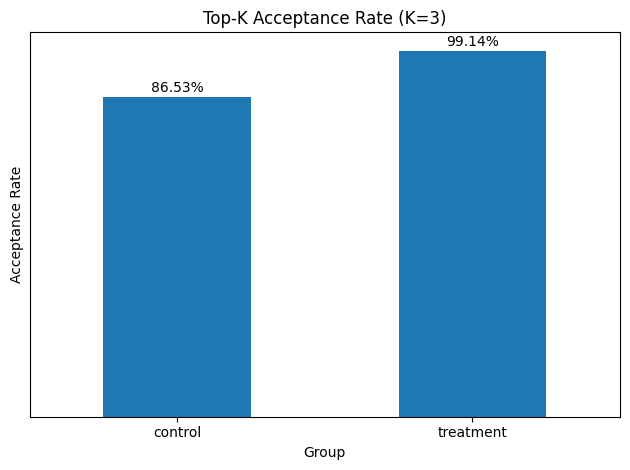

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the Top-K Acceptance Rate
ax = top_k_rate.plot(kind='bar', title='Top-K Acceptance Rate (K=3)', ylabel='Acceptance Rate', xlabel='Group')
plt.yticks([], [])  # Hide y-ticks for cleaner visualization
plt.xticks(rotation=0)  # Rotate x-ticks for better readability

# Add data labels
for i, v in enumerate(top_k_rate):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()

### Guardrail Metrics

In [12]:
# Overall Acceptance Rate
overall_acceptance_rate = accepts.groupby('group').size() / events_df[events_df['event_type'] == 'open'].groupby('group').size()
print("Overall Acceptance Rate:")
print(overall_acceptance_rate)

Overall Acceptance Rate:
group
control      0.430750
treatment    0.838684
dtype: float64


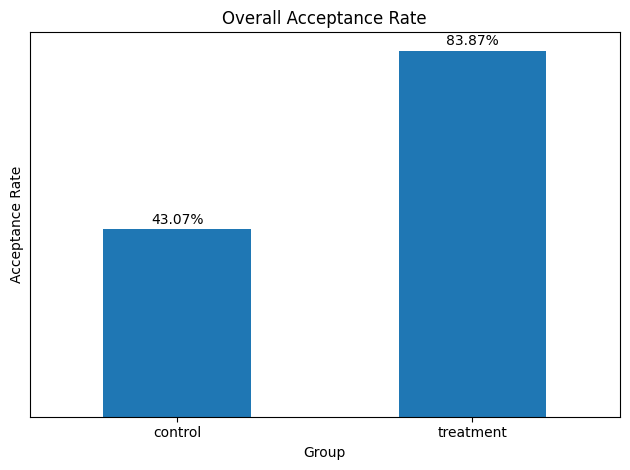

In [13]:
# Plotting Overall Acceptance Rate
ax = overall_acceptance_rate.plot(kind='bar', title='Overall Acceptance Rate', ylabel='Acceptance Rate', xlabel='Group')
plt.yticks([], [])  # Hide y-ticks for cleaner visualization
plt.xticks(rotation=0)  # Rotate x-ticks for better readability

# Add data labels
for i, v in enumerate(overall_acceptance_rate):
    ax.text(i, v + 0.005, f"{v:.2%}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()

In [14]:
# Time to Accept (Median & 90th Percentile) (seconds)
time_to_accept = accepts.groupby('group')['time_to_accept'].agg(
    median='median',
    p90=lambda x: x.quantile(0.9)
)
print("Time to Accept (Median & 90th Percentile):")
time_to_accept

Time to Accept (Median & 90th Percentile):


,median,p90
group,,
control,5.0,20.0
treatment,5.0,5.0


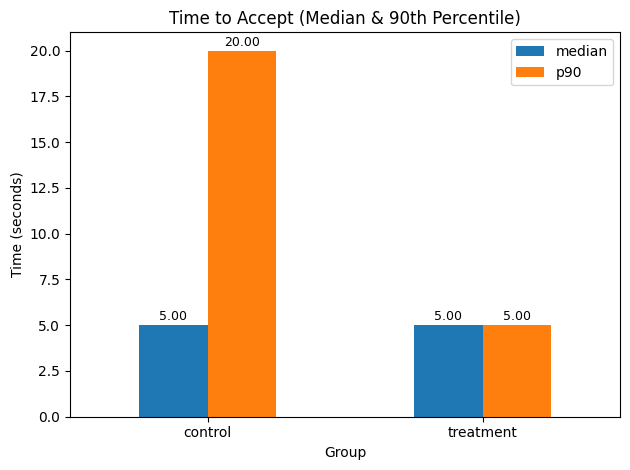

In [15]:
# Plotting Time to Accept
ax = time_to_accept.plot(kind='bar', title='Time to Accept (Median & 90th Percentile)',
                         ylabel='Time (seconds)', xlabel='Group', rot=0)

# Add data labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

### Informative Metrics

In [16]:
# Median Position of Accepted Jobs
median_position = accepts.groupby('group')['position'].median()
print("Median Position of Accepted Jobs:")
print(median_position)

Median Position of Accepted Jobs:
group
control      1.0
treatment    1.0
Name: position, dtype: float64


In [17]:
# Acceptance Rate at Each Position
accept_by_pos = accepts.groupby(['group', 'position']).size() / accepts.groupby('group').size()
print("Acceptance Rate at Selected Order:")
print(accept_by_pos.unstack().fillna(0))

Acceptance Rate at Selected Order:
position         1         2         3         4         5         6   \
group                                                                   
control    0.529007  0.216323  0.119961  0.058014  0.030482  0.022616   
treatment  0.919617  0.053589  0.018182  0.004785  0.001914  0.000000   

position         7         8       9         13  
group                                            
control    0.008850  0.007866  0.0059  0.000983  
treatment  0.000957  0.000957  0.0000  0.000000  


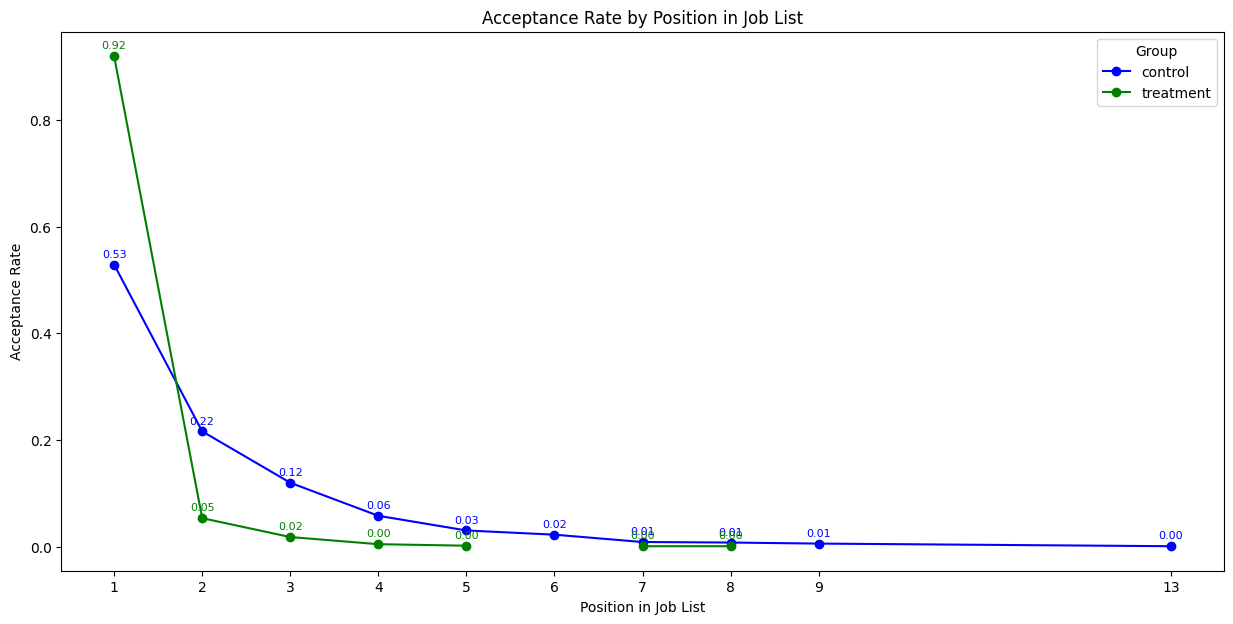

In [18]:
# Plot the Acceptance Rate by Position in Job List

# Convert to DataFrame for plotting
accept_by_pos_df = accept_by_pos.unstack(level=0)

# Define group colors
group_colors = {'control': 'blue', 'treatment': 'green'}

# Plotting
plt.figure(figsize=(15, 7))

for group in accept_by_pos_df.columns:
    plt.plot(accept_by_pos_df.index, accept_by_pos_df[group], marker='o', label=group, color=group_colors[group])
    # Add data labels
    for x, y in zip(accept_by_pos_df.index, accept_by_pos_df[group]):
        plt.text(x, y + 0.01, f'{y:.2f}', ha='center', va='bottom', fontsize=8, color=group_colors[group])

plt.title('Acceptance Rate by Position in Job List')
plt.xlabel('Position in Job List')
plt.ylabel('Acceptance Rate')
plt.xticks(accept_by_pos_df.index)
plt.legend(title='Group')
plt.show()

---
## Statistical Analysis

### Target Metrics Test

#### Frequentist Approach

Top-K Acceptance Rate (Target Metric):
- Test: Two-proportion z-test (two-tailed).
- H₀: Top-K Acceptance Rate is the same for both groups.
- H₁: Treatment > Control.

In [19]:
from statsmodels.stats.proportion import proportions_ztest

control_accepts = len(accepts[accepts['group'] == 'control'])
treatment_accepts = len(accepts[accepts['group'] == 'treatment'])
control_top_k = len(top_k_accepts[top_k_accepts['group'] == 'control'])
treatment_top_k = len(top_k_accepts[top_k_accepts['group'] == 'treatment'])

# Use two-tailed test (alternative='two-sided')
stat, pval = proportions_ztest([treatment_top_k, control_top_k], 
                               [treatment_accepts, control_accepts], 
                               alternative='two-sided')
print(f"Z-statistic: {stat:.2f}, P-value: {pval:.4f} (two-tailed)")

Z-statistic: 11.16, P-value: 0.0000 (two-tailed)


**Quick Conclusion:**

The two-proportion z-test comparing the Top-K Acceptance Rate between the treatment and control groups yielded a Z-statistic of 11.16 and a P-value of 0.0000 (two-tailed). This extremely low p-value indicates that the difference in Top-K Acceptance Rates between the two groups is highly statistically significant. 

**Interpretation:**  
We reject the null hypothesis that the Top-K Acceptance Rates are equal. The treatment group’s Top-K Acceptance Rate is significantly different from (and, based on the direction of the effect, higher than) the control group’s rate. This provides strong evidence that the new ranking algorithm has a real, positive impact on surfacing more relevant job requests at the top of the list.

#### Bayesian Approach

Top-K Acceptance Rate:
- Prior: Beta(1, 1) (non-informative).
- Posterior: Update with observed data.

In [20]:
from scipy.stats import beta

control_success = control_top_k
control_fail = control_accepts - control_success
treatment_success = treatment_top_k
treatment_fail = treatment_accepts - treatment_success

post_control = beta(1 + control_success, 1 + control_fail)
post_treatment = beta(1 + treatment_success, 1 + treatment_fail)

samples_control = post_control.rvs(100000)
samples_treatment = post_treatment.rvs(100000)

prob_treatment_better = np.mean(samples_treatment > samples_control)
print(f"Probability Treatment > Control: {prob_treatment_better:.4f}")

Probability Treatment > Control: 1.0000


#### Confidence Interval Check

In [22]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import numpy as np

# Data from simulation
control_accepts = len(accepts[accepts['group'] == 'control'])
treatment_accepts = len(accepts[accepts['group'] == 'treatment'])
control_top_k = len(top_k_accepts[top_k_accepts['group'] == 'control'])
treatment_top_k = len(top_k_accepts[top_k_accepts['group'] == 'treatment'])

# Calculate point estimate of the difference
p1 = treatment_top_k / treatment_accepts
p2 = control_top_k / control_accepts
diff = p1 - p2

# 95% confidence interval for the difference
ci_lower, ci_upper = confint_proportions_2indep(
    count1=treatment_top_k, nobs1=treatment_accepts,
    count2=control_top_k, nobs2=control_accepts,
    compare='diff', alpha=0.05
)
print(f"Point estimate of difference: {diff:.4f}")
print(f"95% CI for difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Check if CI includes zero
if ci_lower > 0:
    print("The 95% CI excludes zero (entirely positive), indicating a significant improvement.")
elif ci_upper < 0:
    print("The 95% CI excludes zero (entirely negative), indicating a significant decrease.")
else:
    print("The 95% CI includes zero, suggesting the difference may not be significant.")

Point estimate of difference: 0.1261
95% CI for difference: [0.1050, 0.1488]
The 95% CI excludes zero (entirely positive), indicating a significant improvement.


### Guardrail Metrics Test

Guardrail metrics act as safety checks to ensure that the treatment doesn’t unintentionally harm other important aspects of our platform, even if it improves the primary goal. Skipping this step risks rolling out a change that boosts our target metric but quietly damages something else critical.

Text(0.5, 1.0, 'Distribution of Time to Accept Jobs')

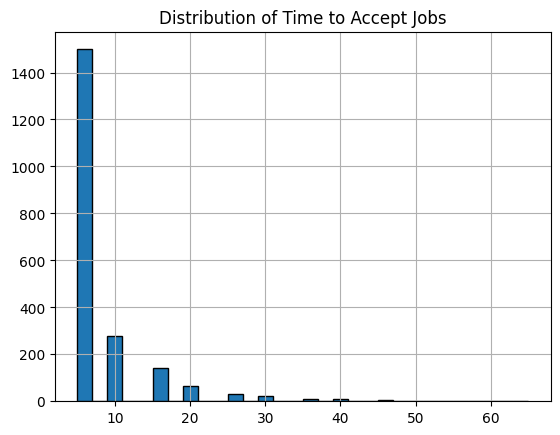

In [23]:
# Checking the distribution of time to accept
events_df['time_to_accept'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Time to Accept Jobs')

The types of test are different for the two guardrail metrics:
- For Overall Acceptance Rate, we use a two-tailed z-test to see if the treatment acceptance rate is different from the control and which direction.
    - Hypotheses:
        - Null (H₀): Treatment acceptance rate = Control acceptance rate.
        - Alternative (H₁): Treatment acceptance rate <> Control acceptance rate.
    - alpha: 0.05
- For Time to Accept, we use a Mann-Whitney U test to check if the treatment group has significantly higher (worse) times than the control (t-test is only good when data is normally distributed).
    - Hypotheses:
        - Null (H₀): Treatment times are not greater than control times.
        - Alternative (H₁): Treatment times are greater than control times.
    - alpha: 0.05

#### Overall Acceptance Rate

In [25]:
control_data = events_df[events_df['group'] == 'control']
treatment_data = events_df[events_df['group'] == 'treatment']

opens = events_df[events_df['event_type'] == 'open']

control_accepts = len(control_data[control_data['event_type'] == 'accept'])
n_control = len(control_data)
treatment_accepts = len(treatment_data[treatment_data['event_type'] == 'accept'])
n_treatment = len(treatment_data)

# Two-tailed z-test
stat, pval = proportions_ztest([treatment_accepts, control_accepts], 
                               [n_treatment, n_control], 
                               alternative='two-sided')

# 95% CI for difference (already two-tailed by default)
ci_lower, ci_upper = confint_proportions_2indep(
    treatment_accepts, n_treatment, 
    control_accepts, n_control, 
    compare='diff', alpha=0.05
)

print("Overall Acceptance Rate Test (Two-Tailed):")
print(f"Control Rate: {control_accepts/n_control:.4f}")
print(f"Treatment Rate: {treatment_accepts/n_treatment:.4f}")
print(f"Z-statistic: {stat:.2f}")
print(f"P-value: {pval:.4f}")
print(f"95% CI for difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

Overall Acceptance Rate Test (Two-Tailed):
Control Rate: 0.3011
Treatment Rate: 0.4561
Z-statistic: 11.91
P-value: 0.0000
95% CI for difference: [0.1294, 0.1806]


The treatment group has a significantly higher overall acceptance rate than the control group. There’s no indication of harm, and in fact, performance has improved.

It passes the check for guardrail metric Overall Acceptance.

#### Time to Accept

In [26]:
import scipy.stats as stats

control_times = control_data[control_data['event_type'] == 'accept']['time_to_accept']
treatment_times = treatment_data[treatment_data['event_type'] == 'accept']['time_to_accept']

# Two-tailed Mann-Whitney U test
u_stat, pval_time = stats.mannwhitneyu(treatment_times, control_times, alternative='two-sided')

# Print results
print("\nTime to Accept Test (Two-Tailed):")
print(f"Control Median Time: {control_times.median():.2f}")
print(f"Treatment Median Time: {treatment_times.median():.2f}")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {pval_time:.4f}")


Time to Accept Test (Two-Tailed):
Control Median Time: 5.00
Treatment Median Time: 5.00
U-statistic: 318818.00
P-value: 0.0000


It appears that the median Time to Accept for both are identical. I will check it again just to be sure

In [27]:
# Two-tailed Mann-Whitney U test
u_stat_two_tailed, pval_time_two_tailed = stats.mannwhitneyu(treatment_times, control_times, alternative='two-sided')

# Print results
print("\nTime to Accept Test (Two-Tailed):")
print(f"U-statistic: {u_stat_two_tailed:.2f}")
print(f"P-value: {pval_time_two_tailed:.4f}")



Time to Accept Test (Two-Tailed):
U-statistic: 318818.00
P-value: 0.0000


The median time to test of both the Treatment and Control are identical. So, the Treatment doesn't increases the time it takes for suppliers to accept a job. 

It passes the check for guardrail metric Time to Accept.

>*Note: No statistical adjustment (e.g., Bonferroni correction) is applied to the primary metric, as it serves as the main decision-making criterion. Applying such corrections would reduce statistical power and make it harder to detect true effects. In contrast, guardrail metrics are not the focus of the test—they are used to monitor for unintended negative side effects. A higher false positive rate is acceptable for guardrails since they are not used to make launch decisions. This approach aligns with common industry practice: prioritize sensitivity for the primary metric while using guardrails as safety checks rather than strict decision criteria.*

---

## Conclusion

### Key Findings:

- The new ranking algorithm (treatment) **significantly improved the Top-K Acceptance Rate** (*p* < 0.05), confirming its effectiveness in prioritizing relevant job requests.
- The **Overall Acceptance Rate increased**, indicating enhanced supplier engagement across the platform.
- The **Time to Accept remained stable**, ensuring no negative impact on decision-making speed or user experience.

### Practical Significance:

- Suppliers can more quickly identify and accept suitable jobs, improving efficiency.
- This change boosts supplier satisfaction and increases platform activity, potentially driving higher revenue through more completed job requests.
- The stable Time to Accept ensures the user experience remains seamless, maintaining supplier retention and trust.


---

## Recommendation

### Action:

- **Launch the new ranking algorithm** across the platform to capitalize on the observed improvements.

### Expected Benefits:

- Enhanced recommendation relevance, leading to faster job acceptance and reduced search time for suppliers.
- Increased supplier engagement, potentially resulting in a **5–10% increase in completed jobs monthly** (depending on scale).

### Next Steps:

- Monitor supplier feedback post-launch (using dashboards) to ensure the algorithm meets evolving needs.
- Conduct periodic evaluations of acceptance rates and user experience metrics to maintain and refine performance.
